In [99]:
"""Imports."""

import collections
import numpy as np
import torch
from matplotlib import pyplot as plt

In [100]:
"""Dataset class."""

DataBatch = collections.namedtuple("DataBatch", ["neural", "behavior"])


class IntegratorDataset():
    def __init__(self, f, duration, sample_rate, start_range):
        """Constructor.
        
        Integrates function f over duration with sample_rate.
        
        The "neural data" is going to be f and the "behavior" is the integral.
        
        Args:
            f: Function to generate the data.
            duration: Duration of the data.
            sample_rate: Sample rate of the data.
            start_range: 2-tuple of ints (min_start_time, max_start_time).
        """
        self._f = f
        self._duration = duration
        self._sample_rate = sample_rate
        self._start_range = start_range
        
    def __call__(self, batch_size):
        """Fetch a batch of data."""
        
        # Generate the data.
        batch_neural = []
        batch_behavior = []
        for _ in range(batch_size):
            start_time = np.random.randint(*self._start_range)
            end_time = start_time + self._duration
            t = np.arange(start_time, end_time, 1 / self._sample_rate)
            neural = self._f(t)
            behavior = np.cumsum(neural) / self._sample_rate
            batch_neural.append(neural)
            batch_behavior.append(behavior)
            
        # Convert to tensors.
        neural = torch.tensor(batch_neural, dtype=torch.float32)
        behavior = torch.tensor(batch_behavior, dtype=torch.float32)
        
        # Add singleton dimension for features.
        neural = neural.unsqueeze(2)
        behavior = behavior.unsqueeze(2)
        
        # Package the data into DataBatch.
        data_batch = DataBatch(neural=neural, behavior=behavior)
        
        return data_batch

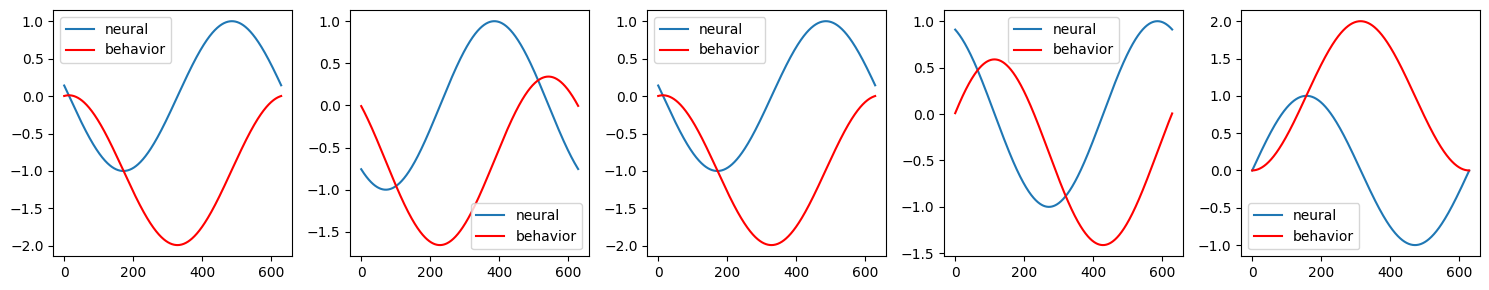

In [101]:
"""Demo dataset."""

# Create dataset object
dataset = IntegratorDataset(
    f=lambda t: np.sin(t),
    duration=2 * np.pi,
    sample_rate=100,
    start_range=(0, 2 * np.pi),
)

# Sample batch of data to plot
num_samples_to_plot = 5
data_batch = dataset(batch_size=num_samples_to_plot)
neural = np.squeeze(data_batch.neural.numpy())
behavior = np.squeeze(data_batch.behavior.numpy())

# Plot batches of data
fig, axes = plt.subplots(
    1, num_samples_to_plot, figsize=(3 * num_samples_to_plot, 3))
for i in range(num_samples_to_plot):
    axes[i].plot(neural[i], label="neural")
    axes[i].plot(behavior[i], color="red", label="behavior")
    axes[i].legend()
fig.tight_layout()

In [102]:
"""Model classes."""


class MLP(torch.nn.Module):
    """MLP network."""
    
    def __init__(self, in_features, layer_features, activation=None):
        """Create MLP module.

        Args:
            in_features: Number of features of the input.
            layer_features: Iterable of ints. Output sizes of the layers.
            activation: Activation function. If None, defaults to Sigmoid.
        """
        super(MLP, self).__init__()

        self._in_features = in_features
        self._layer_features = layer_features
        
        if activation is None:
            activation = torch.nn.Sigmoid()
        self.activation = activation

        features_list = [in_features] + list(layer_features)
        num_layers = len(features_list) - 1
        module_list = []
        for i in range(num_layers):
            layer = torch.nn.Linear(
                in_features=features_list[i],
                out_features=features_list[i + 1],
            )
            module_list.append(layer)
            if i < num_layers - 1:
                module_list.append(activation)

        self.net = torch.nn.Sequential(*module_list)

    def forward(self, x):
        """Apply MLP to input.

        Args:
            x: Tensor of shape [batch_size, ..., in_features].

        Returns:
            Output of shape [batch_size, ..., self.out_features]. An arbitrary
                number of intermediate dimensions will be preserved.
        """
        return self.net(x)

    @property
    def in_features(self):
        return self._in_features

    @property
    def layer_features(self):
        return self._layer_features
        
    @property
    def out_features(self):
        return self._layer_features[-1]


class RNN(torch.nn.Module):
    """Recurrent neural network class."""
    
    def __init__(self, encoder, decoder, tau):
        """Constructor.
        
        This RNN takes in a series of neural data n(t) and outputs a series of
        behavior data b(t).
        
        The update function is this:
            h(t) = (1 - tau) * h(t - 1) + tau * tanh(encoder(h(t - 1), n(t)))
            b(t) = decoder(h(t))
        
        Args:
            encoder: Encoder module. This takes in h(t - 1) and n(t) and outputs
                h(t).
            decoder: Decoder module. THis takes in h(t) and outputs b(t).
            tau: Float in [0, 1]. This is the "leak" factor.
        """
        super(RNN, self).__init__()
        
        self.add_module('encoder', encoder)
        self.add_module('decoder', decoder)
        self._tau = tau
        self._tanh = torch.nn.Tanh()
        
        # Extract hidden state dimensionality
        self._hidden_features = encoder.out_features
    
    def _init_hidden(self, batch_size):
        """Initialize hidden state."""
        return torch.zeros(batch_size, self._hidden_features)
    
    def forward(self, neural):
        """Forward pass.
        
        Args:
            neural: Tensor of shape [batch_size, timesteps, neural_features].
        """
        batch_size, timesteps, _ = neural.shape
        hidden_states = [self._init_hidden(batch_size)]
        for t in range(timesteps):
            # Concatenate previous hidden state with current neural data and
            # apply encoder
            encoder_inputs = torch.cat(
                [hidden_states[-1], neural[:, t, :]], dim=1)
            encoder_outputs = self.encoder(encoder_inputs)
            
            # Compute new hidden state
            delta = self._tau * self._tanh(encoder_outputs)
            new_hidden = (1 - self._tau) * hidden_states[-1] + delta
            
            # Append new hidden state to continue recursing
            hidden_states.append(new_hidden)
        
        # Remove initial hidden state
        hidden_states = hidden_states[1:]
        
        # Stack hidden states into tensor of shape
        # [batch_size, timesteps, hidden_features]
        hidden_states = torch.stack(hidden_states, dim=1)
        
        # Apply decoder
        decoder_outputs = self.decoder(hidden_states)
        
        outputs = {
            'neural': neural,
            'hidden_states': hidden_states,
            'predicted_behavior': decoder_outputs,
        }
        return outputs
    
    def loss(self, data_batch):
        """Compute loss given a batch of neural and behavior data from dataset.
        
        Args:
            data_batch: Namedtuple (or similar structure) with fields 'neural'
                and 'behavior'.
        
        Returns:
            Scalar loss tensor.
        """
        neural = data_batch.neural
        behavior = data_batch.behavior
        
        # Forward pass and extract predicted behavior of shape
        # [batch_size, timesteps, behavior_features]
        rnn_outputs = self.forward(neural)
        predicted_behavior = rnn_outputs['predicted_behavior']
        
        # Take mean over batch and time dimensions and sum over behavior of the
        # squared loss
        squared_error = (predicted_behavior - behavior) ** 2
        loss = torch.mean(torch.sum(squared_error, dim=2))
        
        return loss
        

In [103]:
"""Trainer."""

class Trainer():
    
    def __init__(self,
                 dataset,
                 model,
                 learning_rate,
                 training_steps,
                 batch_size=32,
                 log_period=100,
                 optimizer_class=torch.optim.RMSprop,
                 grad_clip=1.):
        """Constructor.
        
        Args:
            dataset: Dataset object.
            model: Model object.
            learning_rate: Float.
            training_steps: Int.
            batch_size: Int.
            log_period: Int. How frequently to log results.
            optimizer_class: Torch optimizer class.
            grad_clip: Float or None for gradient clipping.
        """
        self._dataset = dataset
        self._model = model
        self._training_steps = training_steps
        self._batch_size = batch_size
        self._log_period = log_period
        self._grad_clip = grad_clip
        
        # Create optimizer
        self._optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    def train(self):
        """Train model on dataset."""
        print('\nBeginning training')
        
        losses = []
        for step in range(self._training_steps + 1):
            self._optimizer.zero_grad()
            loss = self._model.loss(self._dataset(self._batch_size))
            loss.backward()
            if self._grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(
                    self._model.parameters(), self._grad_clip)
            self._optimizer.step()
            losses.append(float(loss.detach()))
            
            if step % self._log_period == 0:
                print(f'    step = {step}, loss = {losses[-1]}')
                
        # Plot losses
        _, ax = plt.subplots(figsize=(6, 3))
        ax.plot(losses)
        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.set_title('Training loss')
                
        return losses


Beginning training
    step = 0, loss = 1.0671943426132202
    step = 100, loss = 0.48058629035949707
    step = 200, loss = 0.2075527310371399
    step = 300, loss = 0.07617148756980896
    step = 400, loss = 0.06396623700857162
    step = 500, loss = 0.06851191073656082
    step = 600, loss = 0.0491376630961895
    step = 700, loss = 0.04175075888633728
    step = 800, loss = 0.043135568499565125
    step = 900, loss = 0.0334797278046608
    step = 1000, loss = 0.039566364139318466
    step = 1100, loss = 0.03157639503479004
    step = 1200, loss = 0.03484979271888733
    step = 1300, loss = 0.026205623522400856
    step = 1400, loss = 0.03406636416912079
    step = 1500, loss = 0.03179841861128807
    step = 1600, loss = 0.02922654338181019
    step = 1700, loss = 0.0340082012116909
    step = 1800, loss = 0.03857135772705078


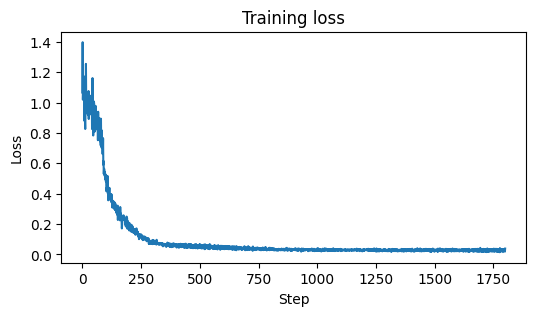

In [104]:
"""Evaluation."""

# Create dataset, model, and trainer
dataset = IntegratorDataset(
    f=lambda t: np.sin(t),
    duration=2 * np.pi,
    sample_rate=10,
    start_range=(0, 2 * np.pi),
)
hidden_features = 32
rnn_model = RNN(
    encoder=MLP(
        in_features=1 + hidden_features,
        layer_features=[128, hidden_features]
    ),
    decoder=MLP(
        in_features=hidden_features,
        layer_features=[1],
    ),
    tau=0.1,
)
trainer = Trainer(
    dataset=dataset,
    model=rnn_model,
    learning_rate=0.0005,
    training_steps=1100,
    batch_size=32,
    log_period=100,
)

# Run trainer
losses = trainer.train()

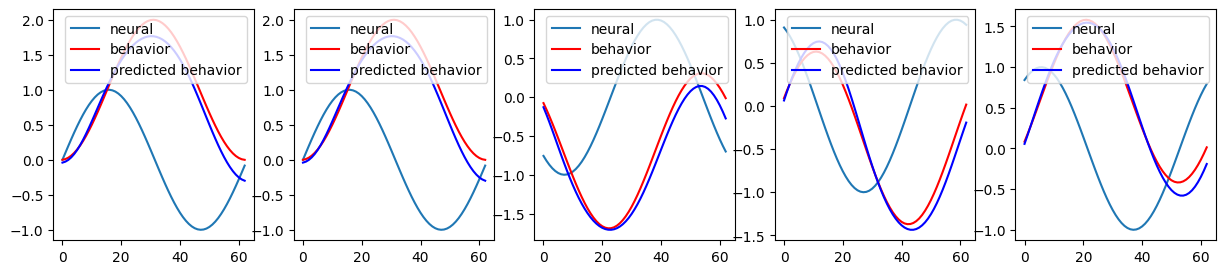

In [105]:
"""Plot model predictions for some samples."""

# Sample a batch of data and run the model on it
num_samples_to_plot = 5
data_batch = dataset(batch_size=num_samples_to_plot)
model_outputs = rnn_model.forward(data_batch.neural)

# Extract data and model predictions to plot
neural = np.squeeze(data_batch.neural.numpy())
behavior = np.squeeze(data_batch.behavior.numpy())
predicted_behavior = np.squeeze(
    model_outputs['predicted_behavior'].detach().numpy())

# Plot data and model predictions
fig, axes = plt.subplots(
    1, num_samples_to_plot, figsize=(3 * num_samples_to_plot, 3))
for i in range(num_samples_to_plot):
    axes[i].plot(neural[i], label="neural")
    axes[i].plot(behavior[i], color="red", label="behavior")
    axes[i].plot(predicted_behavior[i], color="blue", label="predicted behavior")
    axes[i].legend(loc='upper right')